## Week 2 Day 2

Our first Agentic Framework project!!

Prepare yourself for something ridiculously easy.

We're going to build a simple Agent system for generating cold sales outreach emails:
1. Agent workflow
2. Use of tools to call functions
3. Agent collaboration via Tools and Handoffs

## Before we start - some setup:


Please visit Sendgrid at: https://sendgrid.com/

(Sendgrid is a Twilio company for sending emails.)

Please set up an account - it's free! (at least, for me, right now).

Once you've created an account, click on:

Settings (left sidebar) >> API Keys >> Create API Key (button on top right)

Copy the key to the clipboard, then add a new line to your .env file:

`SENDGRID_API_KEY=xxxx`

And also, within SendGrid, go to:

Settings (left sidebar) >> Sender Authentication >> "Verify a Single Sender"  
and verify that your own email address is a real email address, so that SendGrid can send emails for you.


In [1]:
from dotenv import load_dotenv
from agents import Agent, Runner, trace, function_tool
from openai.types.responses import ResponseTextDeltaEvent
from typing import Dict
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
import asyncio



In [2]:
load_dotenv(override=True)

True

## Step 1: Agent workflow

In [3]:
instructions1 = "You are a sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write professional, serious cold emails."

instructions2 = "You are a humorous, engaging sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write witty, engaging cold emails that are likely to get a response."

instructions3 = "You are a busy sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write concise, to the point cold emails."

In [4]:
sales_agent1 = Agent(
        name="Professional Sales Agent",
        instructions=instructions1,
        model="gpt-4o-mini"
)

sales_agent2 = Agent(
        name="Engaging Sales Agent",
        instructions=instructions2,
        model="gpt-4o-mini"
)

sales_agent3 = Agent(
        name="Busy Sales Agent",
        instructions=instructions3,
        model="gpt-4o-mini"
)

In [5]:

result = Runner.run_streamed(sales_agent1, input="Write a cold sales email")
async for event in result.stream_events():
    if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
        print(event.data.delta, end="", flush=True)

Subject: Simplify Your SOC 2 Compliance with ComplAI

Hi [Recipient's Name],

I hope this message finds you well.

Navigating the complexities of SOC 2 compliance can be a daunting task, especially with increasing regulatory standards and the constant need for thorough documentation. At ComplAI, we specialize in transforming the compliance landscape with our AI-powered SaaS solution designed to streamline your SOC 2 processes.

Our platform helps organizations like yours:

- **Automate Documentation**: Reduce manual effort and human error by generating necessary documents effortlessly.
- **Stay Audit-Ready**: Ensure compliance is always maintained, making audits a smoother experience.
- **Gain Insights**: Utilize our analytics tools to identify vulnerabilities and improve operational efficiency.

I would love to schedule a brief call to discuss how ComplAI can specifically benefit [Your Company Name]. Are you available for a quick conversation this week?

Looking forward to your reply.

In [6]:
message = "Write a cold sales email"

with trace("Parallel cold emails"):
    results = await asyncio.gather(
        Runner.run(sales_agent1, message),
        Runner.run(sales_agent2, message),
        Runner.run(sales_agent3, message),
    )

outputs = [result.final_output for result in results]

for output in outputs:
    print(output + "\n\n")


Subject: Simplify Your SOC2 Compliance Journey with ComplAI

Hi [Recipient's Name],

I hope this message finds you well. My name is [Your Name], and I am reaching out to introduce you to ComplAI, an innovative SaaS tool designed to streamline SOC2 compliance and audit preparation, powered by advanced AI technology.

As businesses increasingly prioritize data security and compliance, the complexities involved can be daunting. ComplAI simplifies this process, allowing you to focus on what you do best while ensuring that your organization meets all necessary compliance standards effortlessly.

Here are a few key benefits of using ComplAI:

1. **Automated Documentation**: Our AI-powered platform generates and organizes compliance documentation, saving you countless hours.
  
2. **Real-Time Monitoring**: Keep track of your compliance status with continuous updates and alerts, allowing you to address potential issues proactively.

3. **Seamless Collaboration**: Facilitate better communicatio

In [7]:
sales_picker = Agent(
    name="sales_picker",
    instructions="You pick the best cold sales email from the given options. \
Imagine you are a customer and pick the one you are most likely to respond to. \
Do not give an explanation; reply with the selected email only.",
    model="gpt-4o-mini"
)

In [8]:
message = "Write a cold sales email"

with trace("Selection from sales people"):
    results = await asyncio.gather(
        Runner.run(sales_agent1, message),
        Runner.run(sales_agent2, message),
        Runner.run(sales_agent3, message),
    )
    outputs = [result.final_output for result in results]

    emails = "Cold sales emails:\n\n".join(outputs)

    best = await Runner.run(sales_picker, emails)

    print(f"Best sales email:\n{best.final_output}")


Best sales email:
Subject: Let’s Make SOC2 Compliance Less “Uh-Oh” and More “Aha!” 🎉

Hi [Recipient's Name],

I hope this email finds you brilliantly tackling your to-do list—or at least sipping your third cup of coffee while contemplating your next snack! 

As much as we’d all love to avoid the elephant in the room (or audit, in this case), let’s face it: SOC2 compliance can feel like trying to solve a Rubik's Cube blindfolded. 

But fear not! At ComplAI, we’ve developed an AI-powered SaaS tool designed to turn your compliance woes into a smooth jazz playlist. 🎷✨ With our intuitive platform, you’ll not only breeze through audits but you might even become the office hero who magically makes compliance easier for everyone.

Curious about how we can help you avoid the “audit panic” and turn compliance chaos into a well-oiled machine? Let’s chat! Schedule a quick call [insert link] or just reply to this email—our team is all ears (well, metaphorically speaking, of course).

Looking forwar

Now go and check out the trace:

https://platform.openai.com/traces

## Part 2: use of tools

Now we will add a tool to the mix.

Remember all that json boilerplate and the `handle_tool_calls()` function with the if logic..

In [9]:
sales_agent1 = Agent(
        name="Professional Sales Agent",
        instructions=instructions1,
        model="gpt-4o-mini",
)

sales_agent2 = Agent(
        name="Engaging Sales Agent",
        instructions=instructions2,
        model="gpt-4o-mini",
)

sales_agent3 = Agent(
        name="Busy Sales Agent",
        instructions=instructions3,
        model="gpt-4o-mini",
)

In [10]:
sales_agent1

Agent(name='Professional Sales Agent', instructions='You are a sales agent working for ComplAI, a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. You write professional, serious cold emails.', handoff_description=None, handoffs=[], model='gpt-4o-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=None, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True)

## Steps 2 and 3: Tools and Agent interactions

Remember all that boilerplate json?

Simply wrap your function with the decorator `@function_tool`

In [11]:
@function_tool
def send_email(body: str):
    """ Send out an email with the given body to all sales prospects """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("admin@ai-scientia.com")  # Change to your verified sender
    to_email = To("tcurtis45@gmail.com")  # Change to your recipient
    content = Content("text/plain", body)
    mail = Mail(from_email, to_email, "Sales email", content).get()
    response = sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

### This has automatically been converted into a tool, with the boilerplate json created

In [12]:
# Let's look at it
send_email

FunctionTool(name='send_email', description='Send out an email with the given body to all sales prospects', params_json_schema={'properties': {'body': {'title': 'Body', 'type': 'string'}}, 'required': ['body'], 'title': 'send_email_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x712d1c04a520>, strict_json_schema=True)

### And you can also convert an Agent into a tool

In [13]:
tool1 = sales_agent1.as_tool(tool_name="sales_agent1", tool_description="Write a cold sales email")
tool1

FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x712d0f31a660>, strict_json_schema=True)

### So now we can gather all the tools together:

A tool for each of our 3 email-writing agents

And a tool for our function to send emails

In [14]:
description = "Write a cold sales email"

tool1 = sales_agent1.as_tool(tool_name="sales_agent1", tool_description=description)
tool2 = sales_agent2.as_tool(tool_name="sales_agent2", tool_description=description)
tool3 = sales_agent3.as_tool(tool_name="sales_agent3", tool_description=description)

tools = [tool1, tool2, tool3, send_email]

tools

[FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x712d0f31b4c0>, strict_json_schema=True),
 FunctionTool(name='sales_agent2', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent2_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x712d1c04aca0>, strict_json_schema=True),
 FunctionTool(name='sales_agent3', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales

## And now it's time for our Sales Manager - our planning agent

In [15]:
instructions ="You are a sales manager working for ComplAI. You use the tools given to you to generate cold sales emails. \
You never generate sales emails yourself; you always use the tools. \
You try all 3 sales_agent tools once before choosing the best one. \
You pick the single best email and use the send_email tool to send the best email (and only the best email) to the user."


sales_manager = Agent(name="Sales Manager", instructions=instructions, tools=tools, model="gpt-4o-mini")

message = "Send a cold sales email addressed to 'Dear CEO'"

with trace("Sales manager"):
    result = await Runner.run(sales_manager, message)

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/stop.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Wait - you didn't get an email??</h2>
            <span style="color:#ff7800;">With much thanks to student Chris S. for describing his issue and fixes. 
            If you don't receive an email after running the prior cell, here are some things to check: <br/>
            First, check your Spam folder! Several students have missed that the emails arrived in Spam!<br/>Second, print(result) and see if you are receiving errors about SSL. 
            If you're receiving SSL errors, then please check out theses <a href="https://chatgpt.com/share/680620ec-3b30-8012-8c26-ca86693d0e3d">networking tips</a> and see the note in the next cell. Also look at the trace in OpenAI, and investigate on the SendGrid website, to hunt for clues. Let me know if I can help!
            </span>
        </td>
    </tr>
</table>

### And one more suggestion to send emails from student Oleksandr on Windows 11:

If you are getting certificate SSL errors, then:  
Run this in a terminal: `uv pip install --upgrade certifi`

Then run this code:
```python
import certifi
import os
os.environ['SSL_CERT_FILE'] = certifi.where()
```

Thank you Oleksandr!

## Remember to check the trace

https://platform.openai.com/traces

And then check your email!!


### Handoffs represent a way an agent can delegate to an agent, passing control to it

Handoffs and Agents-as-tools are similar:

In both cases, an Agent can collaborate with another Agent

With tools, control passes back

With handoffs, control passes across



In [16]:

subject_instructions = "You can write a subject for a cold sales email. \
You are given a message and you need to write a subject for an email that is likely to get a response."

html_instructions = "You can convert a text email body to an HTML email body. \
You are given a text email body which might have some markdown \
and you need to convert it to an HTML email body with simple, clear, compelling layout and design."

subject_writer = Agent(name="Email subject writer", instructions=subject_instructions, model="gpt-4o-mini")
subject_tool = subject_writer.as_tool(tool_name="subject_writer", tool_description="Write a subject for a cold sales email")

html_converter = Agent(name="HTML email body converter", instructions=html_instructions, model="gpt-4o-mini")
html_tool = html_converter.as_tool(tool_name="html_converter",tool_description="Convert a text email body to an HTML email body")


In [17]:
@function_tool
def send_html_email(subject: str, html_body: str) -> Dict[str, str]:
    """ Send out an email with the given subject and HTML body to all sales prospects """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("admin@ai-scientia.com")  # Change to your verified sender
    to_email = To("tcurtis45@gmail.com")  # Change to your recipient
    content = Content("text/html", html_body)
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

In [18]:
tools = [subject_tool, html_tool, send_html_email]

In [19]:
tools

[FunctionTool(name='subject_writer', description='Write a subject for a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'subject_writer_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x712d0f31a3e0>, strict_json_schema=True),
 FunctionTool(name='html_converter', description='Convert a text email body to an HTML email body', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'html_converter_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x712d0f31b7e0>, strict_json_schema=True),
 FunctionTool(name='send_html_email', description='Send out an email with the given subject and HTML body to all sales prospects', params_json_schema={

In [21]:
instructions ="You are an email formatter and sender. You receive the body of an email to be sent. \
You first use the subject_writer tool to write a subject for the email, then use the html_converter tool to convert the body to HTML. \
Finally, you use the send_html_email tool to send the email with the subject and HTML body."


emailer_agent = Agent(
    name="Email Manager",
    instructions=instructions,
    tools=tools,
    model="gpt-4o-mini",
    handoff_description="Convert an email to HTML and send it")


### Now we have 3 tools and 1 handoff

In [22]:
tools = [tool1, tool2, tool3]
handoffs = [emailer_agent]
print(tools)
print(handoffs)

[FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x712d0f31b4c0>, strict_json_schema=True), FunctionTool(name='sales_agent2', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent2_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x712d1c04aca0>, strict_json_schema=True), FunctionTool(name='sales_agent3', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_a

In [23]:
sales_manager_instructions = "You are a sales manager working for ComplAI. You use the tools given to you to generate cold sales emails. \
You never generate sales emails yourself; you always use the tools. \
You try all 3 sales agent tools at least once before choosing the best one. \
You can use the tools multiple times if you're not satisfied with the results from the first try. \
You select the single best email using your own judgement of which email will be most effective. \
After picking the email, you handoff to the Email Manager agent to format and send the email."


sales_manager = Agent(
    name="Sales Manager",
    instructions=sales_manager_instructions,
    tools=tools,
    handoffs=handoffs,
    model="gpt-4o-mini")

message = "Send out a cold sales email addressed to Dear CEO from Alice"

with trace("Automated SDR"):
    result = await Runner.run(sales_manager, message)

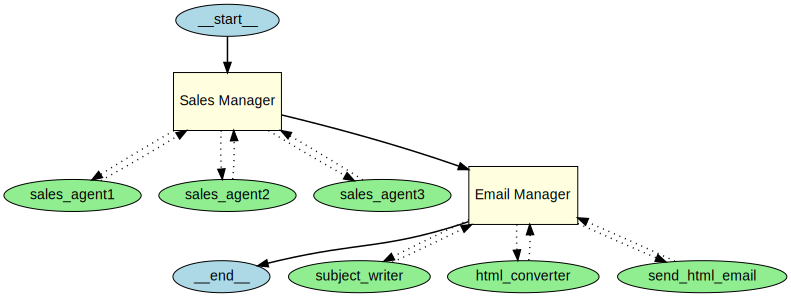

In [25]:
# Visualize the graph (see more here: https://openai.github.io/openai-agents-python/visualization)

# Prerequisites:
# - Installing the visualization extension: uv add "openai-agents[viz]"
# - Installing graphviz (if you don't have it already): 
# -- Mac: brew install graphviz
# -- Windows: visit https://graphviz.org/download/

from agents.extensions.visualization import draw_graph
draw_graph(sales_manager)

### Remember to check the trace

https://platform.openai.com/traces

And then check your email!!

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/exercise.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Exercise</h2>
            <span style="color:#ff7800;">Can you identify the Agentic design patterns that were used here?<br/>
            What is the 1 line that changed this from being an Agentic "workflow" to "agent" under Anthropic's definition?<br/>
            Try adding in more tools and Agents! You could have tools that handle the mail merge to send to a list.<br/><br/>
            HARD CHALLENGE: research how you can have SendGrid call a Callback webhook when a user replies to an email,
            Then have the SDR respond to keep the conversation going! This may require some "vibe coding" 😂
            </span>
        </td>
    </tr>
</table>

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00bfff;">Commercial implications</h2>
            <span style="color:#00bfff;">This is immediately applicable to Sales Automation; but more generally this could be applied to  end-to-end automation of any business process through conversations and tools. Think of ways you could apply an Agent solution
            like this in your day job.
            </span>
        </td>
    </tr>
</table>

## Extra note:

Google has announced their Agent Development Kit (ADK) which is in early preview. It's still under development, so it's too early for us to cover it here. But it's interesting to note that it looks quite similar to OpenAI Agents SDK. To give you a preview, here's a peak at sample code from ADK:

```
root_agent = Agent(
    name="weather_time_agent",
    model="gemini-2.0-flash",
    description="Agent to answer questions about the time and weather in a city.",
    instruction="You are a helpful agent who can answer user questions about the time and weather in a city.",
    tools=[get_weather, get_current_time]
)
```

Well, that looks familiar!